## Questão 2 GABARITO (3.3 pontos)


[Solução da questão](./q2.py)

[Vídeo do gabarito](https://youtu.be/SjwakdVQnI8)


#### Contexto

Você foi contratado por uma empresa de *media tracking* para monitorar quando o logotipo de uma empresa é colocado sobre a programação de uma TV.


<img src=./pomba_red.png width=50%></img>

Créditos: Esta imagem é baseada no arquivo [https://commons.wikimedia.org/wiki/File:Bird_template.svg](https://commons.wikimedia.org/wiki/File:Bird_template.svg)

O vídeo `logomarca.mp4` contém o vídeo de um campeonato de Mountain Bike e deve estar na pasta `q2`. 

Créditos: Este vídeo é baseado no material original de Slavik Petr e está disponível [neste link](https://vimeo.com/67126122).



<img src="./mtb.png"></img>


Existe também uma imagem da pomba em preto e branco em `./pomba_gray.png`

#### Orientações

O código base para este exercício está em `q2/q2.py`. Este exercício **não precisa** de ROS

Dica: Talvez você se interesse pelo notebook de *Feature tracking*.


**O que você deve fazer**:

Apontar corretamente quando o logo desejado aparece na cor correta, contendo o fundo vermelho. Você não deve apontar quando este logo aparecer em preto e branco.

Você deve desenhar um retângulo ao redor do padrão.

O apontamento não precisa ser feito na tela, pode ser feito no terminal.

|Resultado| Conceito| 
|---|---|
| Não executa | 0 |
| Identifica algum pombo corretamente usando features  | 1.8 |
| Faz algum processamento de cor, mas ainda não é perfeito  | 2.3 |
| Funciona perfeitamente | 3.3 | 

Casos intermediários ou omissos da rubrica serão decididos pelo professor.

In [1]:

from __future__ import print_function, division

import cv2
import numpy as np
import imlib
import os
import os.path
import matplotlib.pyplot as plt

import imutils # pip install imutils
import math
%matplotlib inline

print("Versao da Cv2 ", cv2.__version__)
import sys
print("Versao do Python", sys.version)
# print("Diretório de trabalho: ", os.getcwd()) # Descomente para verificar onde está trabalhando

def multiplot(imgs, legenda):
    """ Função que plota n imagens BGR em linha"""
    fig, axes = plt.subplots(1,len(imgs), figsize=(26,5))    
    fig.suptitle(legenda)
    if len(imgs)==1: # Peculiaridade do subplot. Não é relevante para a questão
        ax = axes
        ax.imshow(cv2.cvtColor(imgs[0], cv2.COLOR_BGR2RGB))
        return
    for i in range(len(imgs)):
        axes[i].imshow(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB))
        
def multiplot_gray(imgs, legenda):
    """ Função que plota n imagens grayscale em linha"""
    fig, axes = plt.subplots(1,len(imgs), figsize=(26,5))    
    fig.suptitle(legenda)
    if len(imgs)==1: # Peculiaridade do subplot. Não é relevante para a questão
        ax = axes
        ax.imshow(cv2.cvtColor(imgs[0],  vmin=0, vmax=255, cmap="Greys_r"))
        return
    for i in range(len(imgs)):
        axes[i].imshow(imgs[i], vmin=0, vmax=255, cmap="Greys_r")

Versao da Cv2  4.2.0
Versao do Python 3.8.2 | packaged by conda-forge | (default, Apr 24 2020, 07:56:27) 
[Clang 9.0.1 ]


In [2]:
names = "video0113.jpg  video0204.jpg  video0641.jpg video0141.jpg  video0228.jpg  video0716.jpg".split()

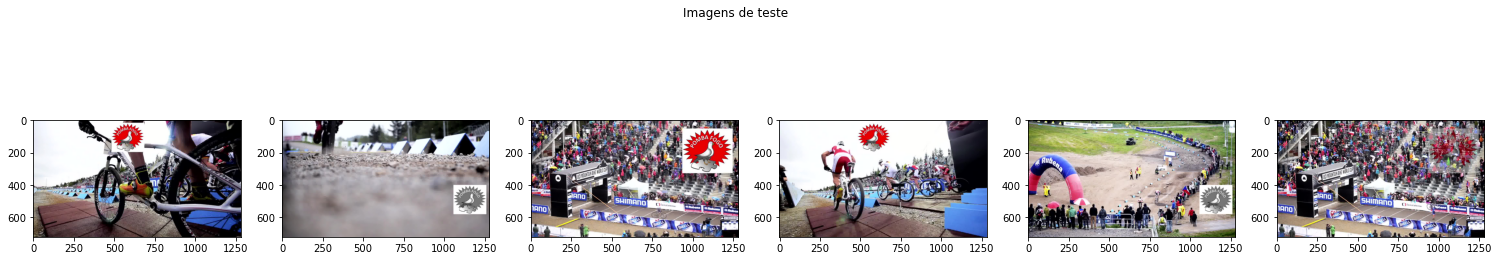

In [3]:
frames = [cv2.imread(os.path.join("frames",f)) for f in names]
multiplot(frames, "Imagens de teste")

## Estratégia

Precisamos verificar se a imagem do vídeo contém o logotipo, o que deve ser feito empregando-se as técnicas de [feature matching](https://github.com/Insper/robot20/blob/master/aula02/BRISK%20Features.ipynb).

Depois de decidir que o logotipo está presente, precisamos ver se ele contém a cor vermelha. 

## Features

In [46]:
def make_list(pts):
    """Transforma uma representação de 4 pontos em uma matriz usada 
        pelo cv2 perspectiveTransform em uma lista de tuplas (x,y)        
    """
    # Remova os comentários para entender como os pontos são armazenados na cv2
    # print("Points:\n", pts) # Para salientar como encontrar os pontos
    # print("dst.shape: ", pts.shape)
    l = []
    for p in pts:
        x = p[0][0]
        y = p[0][1]
        l.append((x,y))
    return l
    

def find_box_corners(pts):        
    """ Versao mais didatica """
    l = make_list(pts)
    print("l: ", l)
    x_coords = [p[0] for p in l]
    y_coords = [p[1] for p in l]
    x_min = int(min(x_coords))
    x_max = int(max(x_coords))
    y_min = int(min(y_coords))
    y_max = int(max(y_coords))       
    return ((x_min,y_min),(x_max,y_max))

def find_box_corners2(pts):
    """Encontra os cantos da bounding box
       Versao mais eficiente de finx_box_corners
    """
    return ((min(pts[:,:,0]), min(pts[:,:,1])), (max(pts[:,:,0]), max(pts[:,:,1])))


def find_homography_draw_box(kp1, kp2, img_cena, good):
    
    out = img_cena.copy()
    
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)


    # Tenta achar uma trasformacao composta de rotacao, translacao e escala que situe uma imagem na outra
    # Esta transformação é chamada de homografia 
    # Para saber mais veja 
    # https://docs.opencv.org/3.4/d9/dab/tutorial_homography.html
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()


    
    h,w = img_original.shape
    # Um retângulo com as dimensões da imagem original
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

    # Transforma os pontos do retângulo para onde estao na imagem destino usando a homografia encontrada
    dst = cv2.perspectiveTransform(pts,M)
   
    corners = find_box_corners(dst)
        

    # Desenha um contorno em vermelho ao redor de onde o objeto foi encontrado
    img2b = cv2.polylines(out,[np.int32(dst)],True,(255,255,0),5, cv2.LINE_AA)
    
    return img2b, corners

In [47]:
# Número mínimo de pontos correspondentes
MIN_MATCH_COUNT = 10


original_bgr =cv2.imread("pomba_gray.png")
# Versões RGB das imagens, para plot
original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)
# Versões grayscale para feature matching
img_original = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2GRAY)

framed = None

# Cria o detector BRISK
brisk = cv2.BRISK_create()

# Encontra os pontos únicos (keypoints) nas duas imagems
kp1, des1 = brisk.detectAndCompute(img_original ,None)

# Configura o algoritmo de casamento de features que vê *como* o objeto que deve ser encontrado aparece na imagem
bf = cv2.BFMatcher(cv2.NORM_HAMMING)    

# Essa parte de baixo deve ir para um loop
def match(des1, cena_bgr):                
    """ Apenas fatoramos código que muda todo frame na parte de baixo """

    img_cena = cv2.cvtColor(cena_bgr, cv2.COLOR_BGR2GRAY)
    
    kp2, des2 = brisk.detectAndCompute(img_cena,None)


    # Tenta fazer a melhor comparacao usando o algoritmo
    matches = bf.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    framed = cena_bgr
    bbox=((0,0),(0,0)) # Caixa vazia de retorno padrão
    
    if len(good)>MIN_MATCH_COUNT:
        # Separa os bons matches na origem e no destino
        print("Matches found")    
        framed, bbox = find_homography_draw_box(kp1, kp2, cena_bgr, good)
    else:
        print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    return framed, bbox


In [58]:
results = []
for fr in frames:    
    img_saida, corners = match(des1, fr)    
    cv2.rectangle(img_saida, corners[0],corners[1], (0,0,255), 4)
    results.append(img_saida)

Matches found
l:  [(481.67355, 16.636726), (481.20474, 197.26778), (684.84033, 196.39996), (685.4037, 16.88119)]
Matches found
l:  [(1055.411, 399.28506), (1057.4026, 577.0935), (1256.5295, 580.277), (1258.5856, 398.00577)]
Matches found
l:  [(931.1116, 52.00862), (930.9457, 326.40704), (1239.1251, 326.7459), (1240.8461, 51.209755)]
Matches found
l:  [(482.35464, 16.895952), (480.27005, 197.90306), (683.5897, 195.32112), (684.0206, 17.482073)]
Matches found
l:  [(1055.1627, 399.03662), (1055.7008, 578.0082), (1256.066, 579.6558), (1258.3276, 398.59982)]
Not enough matches are found - 1/10


## Teste da deteção

A borda vermelha ao redor alguns objetos marca a bounding box

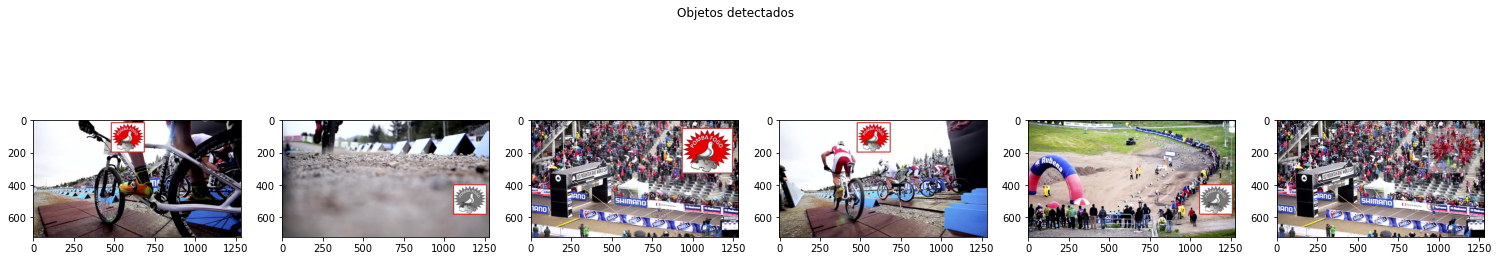

In [60]:
multiplot(results, "Objetos detectados")

Agora precisamos complementar a deteção acima com uma contagem de quantos pixels vermelhos há na região.  Lembremos que o [cormodule.py](https://github.com/Insper/robot20/blob/master/ros/exemplos_python/scripts/cormodule.py) já tinha uma segmentação HSV para o vermelho.

Vamos adaptar a parte de segmentação lá encontrada.

In [61]:
def segmenta_vermelhos(frame):
    """ Recebe uma imagem BGR e devolve uma máscara com os vermelhos selecionados"""
    frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    cor_menor = np.array([0, 50, 50])
    cor_maior = np.array([8, 255, 255])
    segmentado_cor = cv2.inRange(frame_hsv, cor_menor, cor_maior)

    cor_menor = np.array([172, 50, 50])
    cor_maior = np.array([180, 255, 255])
    segmentado_cor += cv2.inRange(frame_hsv, cor_menor, cor_maior)
    
    return segmentado_cor
    

Seleção do canal vermelho nas imagens de teste.

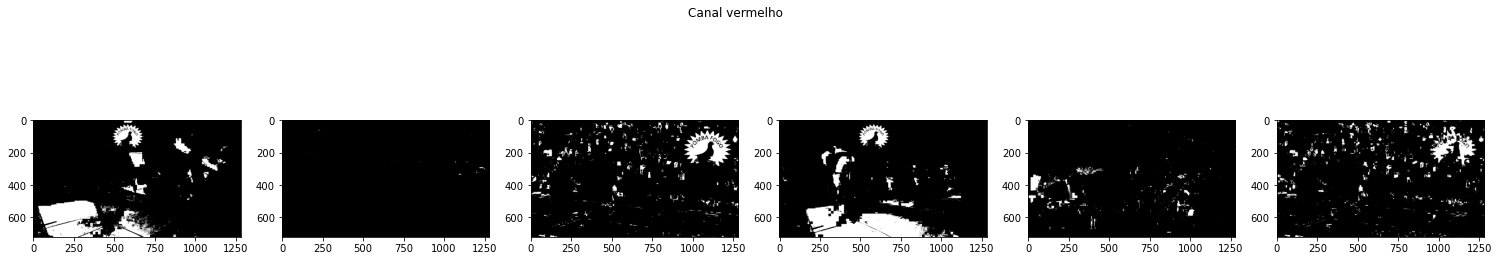

In [64]:
saida_red = []
for f in frames:
    f_red = segmenta_vermelhos(f)
    saida_red.append(f_red)

multiplot(saida_red, "Canal vermelho")

Vamos cruzar 2 abordagens acima: Vamos contar quanto de vermelho existe **onde o logotipo foi encontrado**. 

Para tanto vamos aproveitar **exatamente a mesma** função `count_pixels` que tinha sido desenvolvida para o [gabarito da Q1 na P1 2020](https://github.com/mirwox/prova1_2020/blob/solution/q1/Solucao_Q1.ipynb).


In [76]:
def count_pixels(mask, ponto1, ponto2, txt_color):
    """ Recebe uma mascara binaria e 2 pontos e conta quantos pixels são brancos na mascara"""
    x1, y1 = ponto1
    x2, y2 = ponto2

    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    # Selecionando só a região da imagem com o cachorro
    submask = mask[y1:y2,x1:x2]
    # Somando os pixels 255 e dividindo por 255 para saber quantos são
    pixels = np.sum(submask)/255
    # O resto é só plot
    rgb_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    cv2.rectangle(rgb_mask, ponto1, ponto2, (255,0,0), 3)
    cv2.putText(rgb_mask, "%s:%d"%(txt_color, pixels), (int((x1+x2)/2), int((y1+y2)/2)), font, 1, (0,255,0),1,cv2.LINE_AA)
    return pixels, rgb_mask
    #plt.imshow(submask, cmap="Greys_r", vmin=0, vmax=255)
    #plt.title("(%d , %d) (%d,%d)"%(x1, y1, x2, y2))
    #plt.show()

Testando a contagem de pixels vermelhos:

Matches found
l:  [(481.67355, 16.636726), (481.20474, 197.26778), (684.84033, 196.39996), (685.4037, 16.88119)]
Matches found
l:  [(1055.411, 399.28506), (1057.4026, 577.0935), (1256.5295, 580.277), (1258.5856, 398.00577)]
Matches found
l:  [(931.1116, 52.00862), (930.9457, 326.40704), (1239.1251, 326.7459), (1240.8461, 51.209755)]


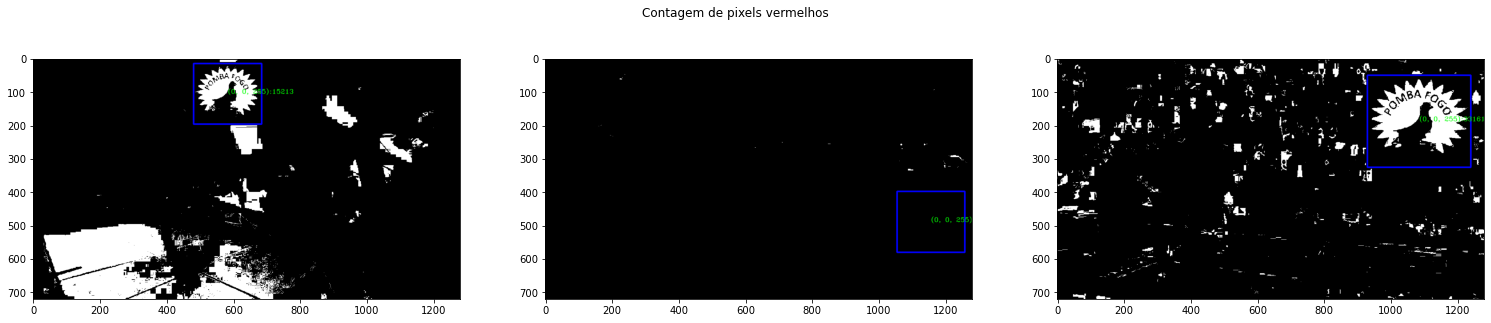

In [77]:
results = []
red_results = []
for fr in frames[0:3]:    
    img_saida, corners = match(des1, fr)    
    cv2.rectangle(img_saida, corners[0],corners[1], (0,0,255), 4)
    red = segmenta_vermelhos(img_saida)
    qtd_vermelhos, saida_count = count_pixels(red,corners[0],corners[1], (0,0,255))
    red_results.append(saida_count)
    results.append(img_saida)
multiplot(red_results, "Contagem de pixels vermelhos")

### Como saber se é o vermelho adequado?

Podemos de forma aproximada contar a proporção de pixels vermelhos na imagem de referência

Matches found
l:  [(0.36033663, 0.26773074), (-0.2306163, 489.08667), (550.9843, 489.03674), (550.5559, 0.5499724)]


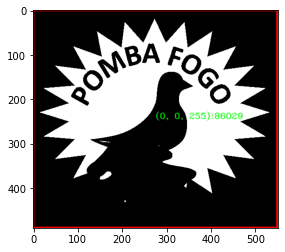

In [78]:
pomba_red = cv2.imread("pomba_red.png")

red_match, corners = match(des1, pomba_red)
cv2.rectangle(red_match, corners[0],corners[1], (0,0,255), 4)
red = segmenta_vermelhos(pomba_red)
qtd_vermelhos, saida_count = count_pixels(red,corners[0],corners[1], (0,0,255))

plt.imshow(saida_count)

In [83]:
def area(pt1, pt2):
    return abs((pt1[0] - pt2[0])*(pt1[1] - pt2[1]))

In [84]:
proporcao = qtd_vermelhos/area(corners[0], corners[1])

Verificando a proporção:

In [86]:
proporcao

0.3198698642870422

Temos que no logotipo original há uma proporção de $31.98\%$ de pixels vermelhos. Vamos adotar alguma tolerância e dizer que apareceu corretamente quando tivermos pelo menos $25\%$.

**Nota** você pode adotar uma tolerância diferente, desde que faça sentido.

A partir de todas as considerações acima, podemos criar nossa função:

In [114]:
tolerancia = 0.25

def processa(frame):
    """Recebe um frame BGR"""
    # Procura o padrao
    red_match, corners = match(des1, frame)
    # Calcula a área do padrão encontrado na imagem
    area_found = area(corners[0], corners[1])
    
    proporcao = -1 # inicializando com um valor imnpossível
    
    # Separa o canal vermelho
    red = segmenta_vermelhos(frame)
    
    # Conta a quantidade e a proporcao de vermelhos
    qtd_vermelhos, saida_count = count_pixels(red,corners[0],corners[1], (0,0,255))  

    plt.figure()
    plt.imshow(imutils.opencv2matplotlib(saida_count))
    
    if area_found>0:
        proporcao = qtd_vermelhos/area_found    
    
    if area_found > 0 and proporcao > tolerancia:
        cv2.rectangle(red_match, corners[0],corners[1], (0,0,255), 10)
        font = cv2.FONT_HERSHEY_COMPLEX_SMALL        
        cv2.putText(red_match, "Encontrado", (corners[0][0], corners[1][1]), font, 3, (0,0,255),2,cv2.LINE_AA)
        print("returning red_match")
        return red_match
    else:
        return frame
     

    

## Versão final

A partir dos testes determinados acima, chegamos nesta versão que pode ser integrada finalmente ao `q2.py`.

Matches found
l:  [(481.67355, 16.636726), (481.20474, 197.26778), (684.84033, 196.39996), (685.4037, 16.88119)]
returning red_match
Matches found
l:  [(1055.411, 399.28506), (1057.4026, 577.0935), (1256.5295, 580.277), (1258.5856, 398.00577)]
Matches found
l:  [(931.1116, 52.00862), (930.9457, 326.40704), (1239.1251, 326.7459), (1240.8461, 51.209755)]
returning red_match
Matches found
l:  [(482.35464, 16.895952), (480.27005, 197.90306), (683.5897, 195.32112), (684.0206, 17.482073)]
returning red_match
Matches found
l:  [(1055.1627, 399.03662), (1055.7008, 578.0082), (1256.066, 579.6558), (1258.3276, 398.59982)]
Not enough matches are found - 1/10


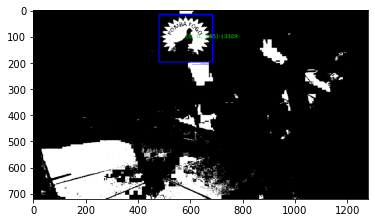

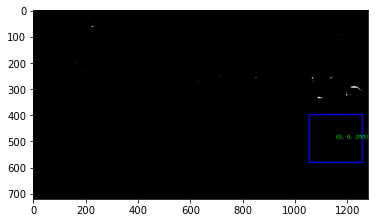

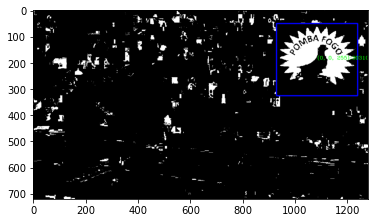

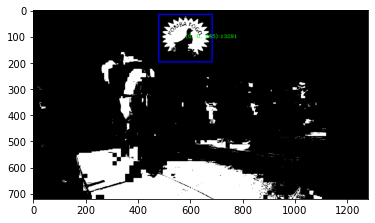

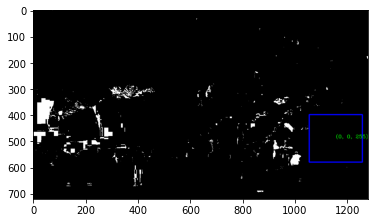

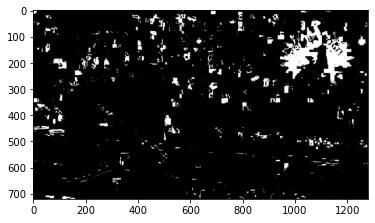

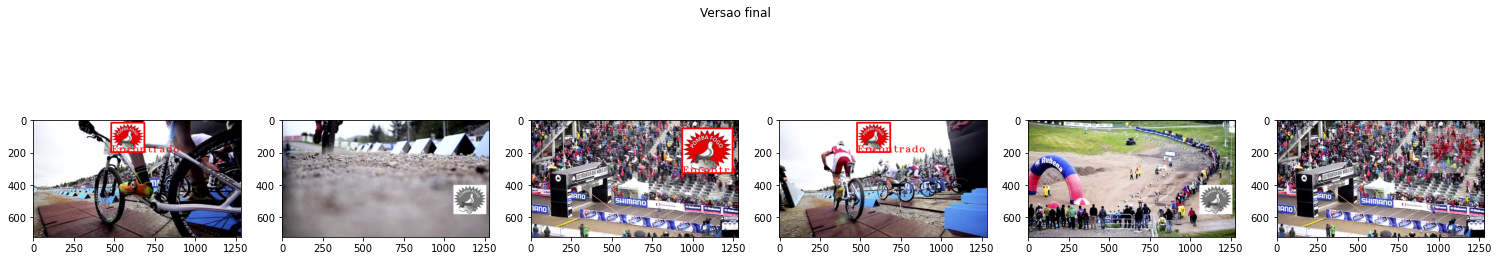

In [115]:
multiplot([processa(f) for f in frames], "Versao final")